Project 1
Python version 3
Juan Carlos Coronel
11/3/17


In [1]:
#%% Libraries

import numpy as np
from numpy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split

In [2]:
#%% Set working directory to Personalizatin Project folder
os.chdir('/Users/juancoronel/Google Drive/home_work/Columbia_Classes/2017_personalization/Personalization Project')

In [3]:
#%%  Explore the movies file (DO NOT RUN THIS AGAIN)
'''
movies = pd.read_csv('./ml-latest-small/movies.csv')
temp = movies[['movieId','title']].reset_index()
movies = temp.rename(columns={'index':'new_movieId'})
movies.to_csv('./data/movies_newid', index=False)
'''
movies = pd.read_csv('./data/movies_newid')
movies.head()

,new_movieId,movieId,title
0,0,1,Toy Story (1995)
1,1,2,Jumanji (1995)
2,2,3,Grumpier Old Men (1995)
3,3,4,Waiting to Exhale (1995)
4,4,5,Father of the Bride Part II (1995)


In [4]:
#%% Split data to train and test DO NOT RUN THIS AGAIN

rawdata = pd.read_csv('/Users/juancoronel/Downloads/ml-latest-small/ratings.csv')
# replace the movie ID with the new movie id
rawdata = pd.merge(rawdata,movies[['new_movieId','movieId']],how='left',left_on='movieId',right_on='movieId')
rawdata = rawdata[['userId','new_movieId','rating']].rename(columns={'userId':'user_id', 'new_movieId':'movie_id'})

In [17]:
# Normalize ratings !!! substract the users mean rating
#rawdata['rating'] = rawdata['rating']-rawdata['rating'].mean()
temp =rawdata.groupby('user_id')['rating'].mean()
rawdata.head()

,user_id,movie_id,rating
0,1,30,2.5
1,1,833,3.0
2,1,859,3.0
3,1,906,2.0
4,1,931,4.0


In [4]:
rawdata_train, rawdata_test = train_test_split(rawdata,test_size=0.2)
#rawdata_test.to_csv('./data/ratings_test.csv',index=False, header=False)
#rawdata_train.to_csv('./data/ratings_train.csv',index=False, header=False)

#rawdata = pd.read_csv('./data/ratings_train.csv')
print(rawdata_train.shape, ' Train Data')
print(rawdata_test.shape, ' Test Data')
rawdata_train.head()

(80003, 3)  Train Data
(20001, 3)  Test Data


,user_id,movie_id,rating
56186,405,3888,0.456392
65195,463,3173,0.456392
79662,547,4258,-0.043608
19519,130,1146,0.456392
56821,408,1446,1.456392


In [5]:
#%% Import Training data
#rawdata = pd.read_csv('./data/ratings_train.csv', names=['user_id','movie_id','rating'])
rawdata=rawdata_train
M = np.zeros((rawdata['user_id'].max()+1,rawdata['movie_id'].max()+1))
M[:,:] = np.nan
Mtest = np.zeros((rawdata['user_id'].max()+1,rawdata['movie_id'].max()+1))
Mtest[:,:] = np.nan

rawdata = np.asanyarray(rawdata)
for uid, mid, rating in rawdata:
    M[int(uid),int(mid)] = rating

MTF = ~np.isnan(M)
M0 = np.nan_to_num(M)

In [6]:
# Import TEST Data
#rawdata = pd.read_csv('./data/ratings_test.csv', names=['user_id','movie_id','rating'])
rawdata = rawdata_test
rawdata = np.asanyarray(rawdata)
for uid, mid, rating in rawdata:
    Mtest[int(uid),int(mid)] = rating

MtestTF = ~np.isnan(Mtest)

In [7]:
#%% Set model variables
d= 10
sigma = 0.25
lam = 1

iterations = 100
rounds = 2

In [8]:
#%%
#M = pd.pivot(M[0],M[1],M[2])
#M = np.asanyarray(M)
objective_all = np.zeros((iterations,rounds))
rmse_obj = pd.DataFrame(np.zeros((10,4)), columns= ['round', 'mae', 'rmse', 'objective'])
objective_best = 0

In [9]:
#%% Running the same model 5 times. The model does 100 itterations
for r in range(rounds):    
    #Initialize U and V
    U = np.random.randn(M.shape[0],d)
    V = np.random.randn(d,M.shape[1])
    #V = pd.read_csv('v_init_jc.csv',header= None)
    #V = np.asanyarray(V)
    
    omega = np.nan_to_num(np.divide(M,M))
    objective = np.array([])
    
    #
    for n in range(iterations):
        #
    
        for i in range(M.shape[0]):
            #temp = V.dot(omega[i]*np.identity(len(omega[i]))).dot(V.T)
            #
            mask = MTF[i,:]
            temp = V[:,mask].dot(V[:,mask].T)
            temp = lam*sigma*np.identity(len(temp)) + temp
            temp = np.linalg.inv(temp)
            #temp = temp.dot(V.dot(M0[i]))
            temp = temp.dot(V[:,mask].dot(M[i,:][mask]))
            U[i] = temp
        #  
        for j in range(M.shape[1]):
            #temp = U.T.dot(omega[:,j]*np.identity(len(omega[:,j]))).dot(U)
            mask = MTF[:,j]
            temp = U.T[:,mask].dot(U.T[:,mask].T)
            temp = lam*sigma*np.identity(len(temp)) + temp
            temp = np.linalg.inv(temp)
            #temp = temp.dot(U.T.dot(M0[:,j]))  # Are the indexs correct?
            temp = temp.dot(U.T[:,mask].dot(M[:,j][mask]))
            V[:,j] = temp
        #
        print(n, ':iteration  ', r, ':Round')
    
        # Get all my predictions
        Mguess = U.dot(V)
        #Mguess1 = Mguess
        #
        
        # COLLECT OUTPUTS:  
        # Calculate my Objective function
        #temp = omega * Mguess
        #temp = (1/(2*sigma)) * np.abs(M0 - temp)**2
        temp = (1/(2*sigma)) * np.linalg.norm(M[MTF] - Mguess[MTF])**2
        
        #temp = temp.sum()       
        temp = -temp - ((lam/2)*(np.linalg.norm(U)**2))
        temp = temp - ((lam/2)*(np.linalg.norm(V)**2))
        
        #if n>0:
        #print(temp, ":Objective  ", r,' :round')    
        objective = np.append(objective, temp)
        
    objective_all[:,r] = objective
    
    # Save the best V
    if -objective[-1]> objective_best:
        objective_best = -objective[-1]
        V_final = V
        U_final = U
        Mguess_final = Mguess
        print(r,' Best Round')
    # Calculate the RMSE
    mae = (np.abs(Mguess[MtestTF] - Mtest[MtestTF]).sum())/MtestTF.sum()
    rmse = np.sqrt((((Mguess[MtestTF] - Mtest[MtestTF])**2).sum())/MtestTF.sum())
    rmse_obj.iloc[r] = [r, mae, rmse, temp]

0 :iteration   0 :Round
1 :iteration   0 :Round
2 :iteration   0 :Round
3 :iteration   0 :Round
4 :iteration   0 :Round
5 :iteration   0 :Round
6 :iteration   0 :Round
7 :iteration   0 :Round
8 :iteration   0 :Round
9 :iteration   0 :Round
10 :iteration   0 :Round
11 :iteration   0 :Round
12 :iteration   0 :Round
13 :iteration   0 :Round
14 :iteration   0 :Round
15 :iteration   0 :Round
16 :iteration   0 :Round
17 :iteration   0 :Round
18 :iteration   0 :Round
19 :iteration   0 :Round
20 :iteration   0 :Round
21 :iteration   0 :Round
22 :iteration   0 :Round
23 :iteration   0 :Round
24 :iteration   0 :Round
25 :iteration   0 :Round
26 :iteration   0 :Round
27 :iteration   0 :Round
28 :iteration   0 :Round
29 :iteration   0 :Round
30 :iteration   0 :Round
31 :iteration   0 :Round
32 :iteration   0 :Round
33 :iteration   0 :Round
34 :iteration   0 :Round
35 :iteration   0 :Round
36 :iteration   0 :Round
37 :iteration   0 :Round
38 :iteration   0 :Round
39 :iteration   0 :Round
40 :iterat

0
1
2
3
4


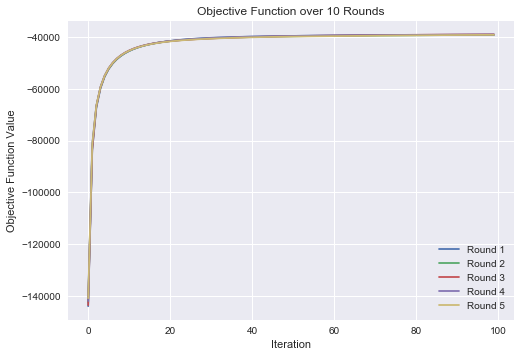

In [22]:
#%%     Plot objective function
temp = pd.DataFrame(objective_all)
for i in range(rounds):
    #plt.scatter(range(1,100), objective_all[:,i], alpha= .5, s= 15, label= 'Round %i' %(i+1))
    plt.plot(objective_all[:,i], label= 'Round %i' %(i+1))
    plt.legend()
    plt.title('Objective Function over 10 Rounds')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Function Value')
    print(i)
plt.show()

In [30]:
#%% data checks
print(rawdata2.user_id.nunique(), '# of unique users')
print(rawdata2.user_id.max(), 'Highest user ID', '\n')

print(rawdata2.movie_id.nunique(), '# of unique movies')
print(rawdata2.movie_id.max(), 'Highest movie ID')

671 # of unique users
671 Highest user ID 

9066 # of unique movies
9122 Highest movie ID


In [15]:
#%% Set variables for model execution
# d is the k or factors of the matrix
d= 10
sigma = 0.25
lam = 1

iterations = 100
rounds = 3

In [31]:
#%% Import Data
#rawdata = pd.read_csv('./COMS4721_hw4-data/ratings.csv',header= None, names= ['user_id', 'movie_id','rating'])

#The line below will make use of the personalization project data set
rawdata = rawdata2

M = np.zeros((rawdata['user_id'].max()+1,rawdata['movie_id'].max()+1))
M[:,:] = np.nan
Mtest = np.zeros((rawdata['user_id'].max()+1,rawdata['movie_id'].max()+1))
Mtest[:,:] = np.nan

rawdata = np.asanyarray(rawdata)
for uid, mid, rating in rawdata:
    M[int(uid),int(mid)] = rating
# Here we use a mask (MTF) to replace cells with out ratings with zero
M, Mtest = train_test_split(M,test_size=0.3)
MTF = ~np.isnan(M)
M0 = np.nan_to_num(M)

MtestTF = ~np.isnan(Mtest)

In [32]:
#%%
#M = pd.pivot(M[0],M[1],M[2])
#M = np.asanyarray(M)
objective_all = np.zeros((iterations,rounds))
rmse_obj = pd.DataFrame(np.zeros((10,3)), columns= ['round', 'rmse', 'objective'])
objective_best = 0

In [33]:
#%%
for r in range(rounds):    
    #Initialize U and V
    U = np.random.randn(M.shape[0],d)
    V = np.random.randn(d,M.shape[1])
    #V = pd.read_csv('v_init_jc.csv',header= None)
    #V = np.asanyarray(V)
    
    omega = np.nan_to_num(np.divide(M,M))
    objective = np.array([])
    
    #
    for n in range(iterations):
        #
    
        for i in range(M.shape[0]):
            #temp = V.dot(omega[i]*np.identity(len(omega[i]))).dot(V.T)
            #
            mask = MTF[i,:]
            temp = V[:,mask].dot(V[:,mask].T)
            temp = lam*sigma*np.identity(len(temp)) + temp
            temp = np.linalg.inv(temp)
            #temp = temp.dot(V.dot(M0[i]))
            temp = temp.dot(V[:,mask].dot(M[i,:][mask]))
            U[i] = temp
        #  
        for j in range(M.shape[1]):
            #temp = U.T.dot(omega[:,j]*np.identity(len(omega[:,j]))).dot(U)
            mask = MTF[:,j]
            temp = U.T[:,mask].dot(U.T[:,mask].T)
            temp = lam*sigma*np.identity(len(temp)) + temp
            temp = np.linalg.inv(temp)
            #temp = temp.dot(U.T.dot(M0[:,j]))  # Are the indexs correct?
            temp = temp.dot(U.T[:,mask].dot(M[:,j][mask]))
            V[:,j] = temp
        #
        print(n, ':iteration  ', r, ':Round')
    
        # Get all my predictions
        Mguess = U.dot(V)
        Mguess1 = Mguess
        #
        
        # COLLECT OUTPUTS:  
        # Calculate my Objective function
        #temp = omega * Mguess
        #temp = (1/(2*sigma)) * np.abs(M0 - temp)**2
        temp = (1/(2*sigma)) * np.linalg.norm(M[MTF] - Mguess[MTF])**2
        
        #temp = temp.sum()       
        temp = -temp - ((lam/2)*(np.linalg.norm(U)**2))
        temp = temp - ((lam/2)*(np.linalg.norm(V)**2))
        
        #if n>0:
        #print(temp, ":Objective  ", r,' :round')    
        objective = np.append(objective, temp)
        
    objective_all[:,r] = objective
    
    # Save the best V
    if -objective[-1]> objective_best:
        objective_best = -objective[-1]
        V_final = V
        print(r,' Best Round')
    # Calculate the RMSE
    rmse = (((Mguess[MtestTF] - Mtest[MtestTF])**2).sum())/MtestTF.sum()
    rmse_obj.iloc[r] = [r, rmse, temp]
    

0 :iteration   0 :Round
1 :iteration   0 :Round
2 :iteration   0 :Round
3 :iteration   0 :Round
4 :iteration   0 :Round
5 :iteration   0 :Round
6 :iteration   0 :Round
7 :iteration   0 :Round
8 :iteration   0 :Round
9 :iteration   0 :Round
10 :iteration   0 :Round
11 :iteration   0 :Round
12 :iteration   0 :Round
13 :iteration   0 :Round
14 :iteration   0 :Round
15 :iteration   0 :Round
16 :iteration   0 :Round
17 :iteration   0 :Round
18 :iteration   0 :Round
19 :iteration   0 :Round
20 :iteration   0 :Round
21 :iteration   0 :Round
22 :iteration   0 :Round
23 :iteration   0 :Round
24 :iteration   0 :Round
25 :iteration   0 :Round
26 :iteration   0 :Round
27 :iteration   0 :Round
28 :iteration   0 :Round
29 :iteration   0 :Round
30 :iteration   0 :Round
31 :iteration   0 :Round
32 :iteration   0 :Round
33 :iteration   0 :Round
34 :iteration   0 :Round
35 :iteration   0 :Round
36 :iteration   0 :Round
37 :iteration   0 :Round
38 :iteration   0 :Round
39 :iteration   0 :Round
40 :iterat

/Users/juancoronel/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:66: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 470 but corresponding boolean dimension is 202


0 :iteration   1 :Round
1 :iteration   1 :Round
2 :iteration   1 :Round
3 :iteration   1 :Round
4 :iteration   1 :Round
5 :iteration   1 :Round
6 :iteration   1 :Round
7 :iteration   1 :Round
8 :iteration   1 :Round
9 :iteration   1 :Round
10 :iteration   1 :Round
11 :iteration   1 :Round
12 :iteration   1 :Round
13 :iteration   1 :Round
14 :iteration   1 :Round
15 :iteration   1 :Round
16 :iteration   1 :Round
17 :iteration   1 :Round
18 :iteration   1 :Round
19 :iteration   1 :Round
20 :iteration   1 :Round
21 :iteration   1 :Round
22 :iteration   1 :Round
23 :iteration   1 :Round
24 :iteration   1 :Round
25 :iteration   1 :Round
26 :iteration   1 :Round
27 :iteration   1 :Round
28 :iteration   1 :Round
29 :iteration   1 :Round
30 :iteration   1 :Round
31 :iteration   1 :Round
32 :iteration   1 :Round
33 :iteration   1 :Round
34 :iteration   1 :Round
35 :iteration   1 :Round
36 :iteration   1 :Round
37 :iteration   1 :Round
38 :iteration   1 :Round
39 :iteration   1 :Round
40 :iterat

0
1
2


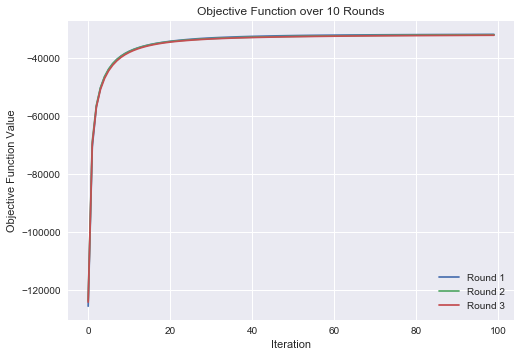

In [38]:
#%%     Plot objective function
temp = pd.DataFrame(objective_all)
for i in range(rounds):
    #plt.scatter(range(1,100), objective_all[:,i], alpha= .5, s= 15, label= 'Round %i' %(i+1))
    plt.plot(objective_all[:,i], label= 'Round %i' %(i+1))
    plt.legend()
    plt.title('Objective Function over 10 Rounds')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Function Value')
    print(i) 
plt.show()

In [60]:
movies.head()

,new_movieId,movieId,title
0,0,1,Toy Story (1995)
1,1,2,Jumanji (1995)
2,2,3,Grumpier Old Men (1995)
3,3,4,Waiting to Exhale (1995)
4,4,5,Father of the Bride Part II (1995)


In [59]:
#%% Which movies are Star Wars
# 966 Star Wars: Episode VI - Return of the Jedi (1983)
# 5624 Saw (2004)

#pd.DataFrame(Mguess)
mask = movies.title.str.contains('saw', case=False)
movies[mask]

,new_movieId,movieId,title
789,789,972,"Last Time I Saw Paris, The (1954)"
1966,1966,2459,"Texas Chainsaw Massacre, The (1974)"
1967,1967,2460,"Texas Chainsaw Massacre 2, The (1986)"
1968,1968,2461,Leatherface: Texas Chainsaw Massacre III (1990)
1969,1969,2462,Texas Chainsaw Massacre: The Next Generation (...
2286,2286,2856,I Saw What You Did (1965)
4859,4859,6880,"Texas Chainsaw Massacre, The (2003)"
5624,5624,8957,Saw (2004)
6272,6272,39446,Saw II (2005)
6540,6540,48518,"Texas Chainsaw Massacre: The Beginning, The (2..."


In [62]:
#%%  Find the 10 closest movies using Vj (movies: 50(Star Wars), 182(Goodfellas), 485(My Fair Lady))
movie_dist = np.zeros((V.shape[1],3))

In [63]:
#%%
for i in range(V.shape[1]):
    movie_dist[i,0] = np.linalg.norm( V_final[:,966] - V_final[:,i])
    movie_dist[i,1] = np.linalg.norm(V_final[:,5624] - V_final[:,i])
    movie_dist[i,2] = np.linalg.norm(V_final[:,1] - V_final[:,i])
movie_dist_df = pd.DataFrame(movie_dist, columns= ['Star_Wars', 'Saw', 'Toy_Story'])

In [ ]:
#%%
#temp = pd.read_table('./COMS4721_hw4-data/movies.txt', sep= '\n', header= None, names= ['Movies'])
temp['Star_Wars'] = movie_dist_df['Star_Wars']
temp['Saw'] = movie_dist_df['Saw']
temp['Toy_Story'] = movie_dist_df['Toy_Story']
movie_dist_df = temp

In [ ]:
#%%
temp = pd.DataFrame()
temp['Star_Wars'] = movie_dist_df.sort_values(by= 'Star_Wars').iloc[1:11,0].reset_index(drop= True)
temp['Saw'] = movie_dist_df.sort_values(by= 'Saw').iloc[1:11,0].reset_index(drop= True)
temp['Toy_Story'] = movie_dist_df.sort_values(by= 'Toy_Story').iloc[1:11,0].reset_index(drop= True)

In [ ]:
#%% TEST CODE
temp


#%%
rmse_obj
#%%